In [25]:
import torch
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sb
import torch.nn.functional as F
import pytorch_lightning as pl
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torchmetrics import F1Score
import wandb
from pytorch_lightning.loggers import WandbLogger
import OSSE_DataLoader
import torchvision.transforms as transforms

import warnings
warnings.filterwarnings('ignore')

In [26]:
#3992370031028f22c45bf7c639d150a61cd79a84
wandb.login()

True

# Load data

In [27]:
from OSSE_DataLoader import get_xarray, get_data_loaders, normalize_osse

OSSE_train, eddies_train, OSSE_test =  get_xarray() # parent_dir = "./data"

OSSE_train_norm, OSSE_test_norm, OSSE_train_mean, OSSE_train_std = normalize_osse(OSSE_train, OSSE_test)

batch_size = 8
augmentations = transforms.Compose(
    [
        transforms.RandomRotation(degrees=40),
        #transforms.RandomCrop(size=(64, 64)),
    ]
)
train_dataloader, val_dataloader = get_data_loaders(
    batch_size, 
    OSSE_train_norm, 
    eddies_train, 
    osse_nan_value=3,
    eddies_nan_value=3,
    augmentations=augmentations,
    )

In [28]:
# count number of data points in each class
def count_classes(data_loader):
    class_count = [0, 0, 0, 0]
    for _, labels in data_loader:
        for i in range(4):
            class_count[i] += (labels == i).sum().item()
    return class_count

class_count = count_classes(train_dataloader)
print(class_count)

[34419701, 3883371, 3837830, 15964061]


In [29]:
# define weights for each class
weights = 1 - (torch.tensor(class_count, dtype=torch.float) / sum(class_count))
print(weights)

tensor([0.4076, 0.9332, 0.9340, 0.7253])


In [30]:
def conv_size_out(hin, win, padding, dilation, kernel_size, stride):
    hout = np.floor(((hin + 2*padding - (dilation * (kernel_size -1 )) -1) / stride ) + 1)
    wout = np.floor(((hin + 2*padding - (dilation * (kernel_size -1 )) -1) / stride ) + 1)
    return hout, wout

def conv_transpose_out(hin, win, padding, dilation, kernel_size, stride):
    hout = np.floor(((hin + 2*padding - (dilation * (kernel_size -1 )) -1) / stride ) + 1)
    wout = np.floor(((hin + 2*padding - (dilation * (kernel_size -1 )) -1) / stride ) + 1)
    return hout, wout

# Model

In [31]:
class classic_CNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # Input 4 x 357 x 717
        self.classes = 4
        self.features = 4 
        self.kernel_size = 3
        self.accuracy = F1Score(task ="multiclass",  num_classes=4, average="weighted")
        # f beta score
        # Encoder
        self.encoder = nn.Sequential( 
            nn.Conv2d(self.features, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 16, 3))
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, 3, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.classes, 3, stride=2, padding=1, output_padding=0))    
            
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x    
        
    def loss_fn(self,ypred,ytrue):        
        if ytrue.shape[0]> 1:
            ytrue= torch.squeeze(ytrue)
        else : 
            ytrue= ytrue[0, :, :, :]
            
        return nn.CrossEntropyLoss(weight=weights)(ypred, ytrue)
    
    def configure_optimizers(self):
        LR = 1e-3
        optimizer = torch.optim.AdamW(self.parameters(),lr=LR)
        return optimizer    
        
    def training_step(self,batch,batch_idx):
        x,y = batch[0],batch[1]
        out = self(x)
        y = y.long()
        loss = self.loss_fn(out,y)
        self.log('train_loss', loss)
        return loss          
    
    def validation_step(self,batch,batch_idx):
        x,y = batch[0],batch[1]
        y = y.long()

        label = y
        out = self(x)
        loss = self.loss_fn(out,label)
        #out = nn.Softmax(-1)(out)
        logits = torch.argmax(out,dim=1, keepdim=True)
        accu = self.accuracy(logits, label)        
        self.log('valid_loss', loss)
        self.log('F1Score', accu)
        return loss, accu

In [32]:
wandb_logger = WandbLogger(project='cnn-lightning', 
                           group='CNN', 
                           job_type='train')

# Training 

In [33]:
model = classic_CNN()
trainer = pl.Trainer(max_epochs = 10, logger=wandb_logger, enable_progress_bar=True)
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type              | Params
-----------------------------------------------
0 | accuracy | MulticlassF1Score | 0     
1 | encoder  | Sequential        | 25.6 K
2 | decoder  | Sequential        | 25.6 K
-----------------------------------------------
51.3 K    Trainable params
0         Non-trainable params
51.3 K    Total params
0.205     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


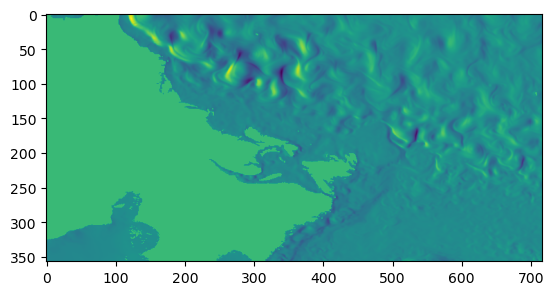

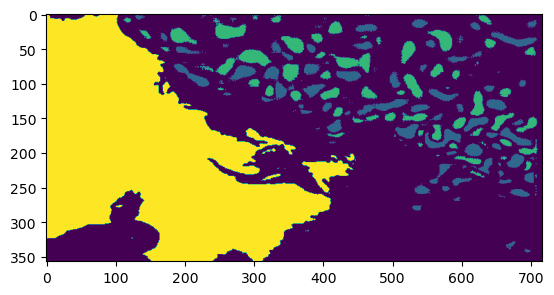

In [34]:
selected_var = ["vomecrtyT", "vozocrtxT", "sossheig", "votemper"]

X_test = torch.tensor(OSSE_test_norm.get(selected_var).to_array().to_numpy())
X_test = X_test.permute(1, 0, 2, 3)
X_test = X_test.nan_to_num(3)

features =X_test[:, :, :, :]
output = model(features)# softmax
#output = nn.Softmax(-1)(output)
logits = torch.argmax(output,dim=1, keepdim=True)
# show the image of 1st sample
plt.imshow(features[1, 0, :, :].cpu().numpy())
plt.show()
# # show the label of 1st sample
# plt.imshow(labels[1, 0, :, :].cpu().numpy())
# plt.show()
# show the predicted label of 1st sample
plt.imshow(logits[1, 0, :, :].cpu().numpy())
plt.show()

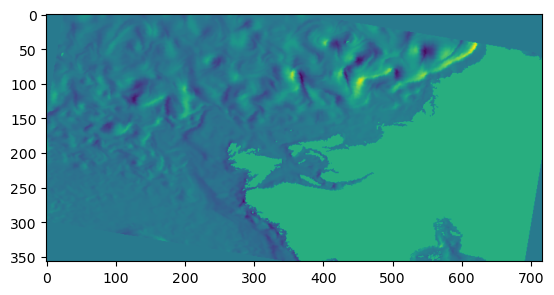

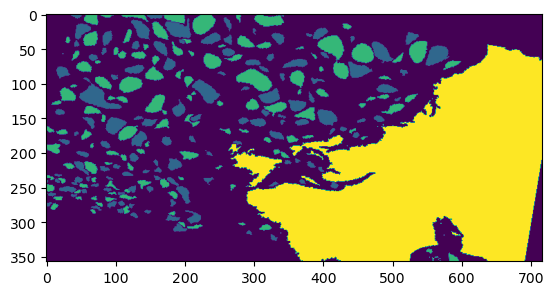

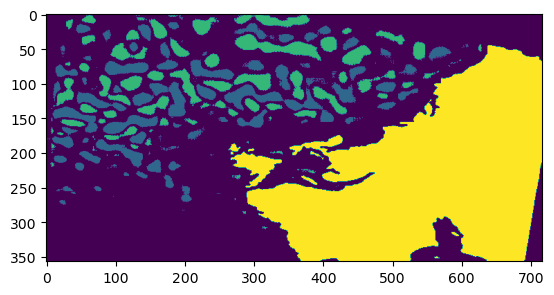

In [35]:

# test on one sample
data_iter = iter(val_dataloader)
features, labels = next(data_iter)
features, labels = next(data_iter)
output = model(features)# softmax
#output = nn.Softmax(-1)(output)
logits = torch.argmax(output,dim=1, keepdim=True)
# show the image of 1st sample
plt.imshow(features[1, 0, :, :].cpu().numpy())
plt.show()
# # show the label of 1st sample
plt.imshow(labels[1, 0, :, :].cpu().numpy())
plt.show()
# show the predicted label of 1st sample
plt.imshow(logits[1, 0, :, :].cpu().numpy())
plt.show()

#wandb.finish()

In [36]:
wandb.finish()

F1Score,▁▅▆▆▇▇████
epoch,▁▂▂▃▃▃▄▅▅▆▆▆▇▇█
train_loss,█▃▂▁▁
trainer/global_step,▁▂▂▃▃▃▄▄▅▆▆▆▇▇█
valid_loss,█▅▄▃▂▂▁▁▁▁
F1Score,0.85415
epoch,9
train_loss,0.38816
trainer/global_step,289
valid_loss,0.38131
